Resulta que gran parte del trabajo con datos implica saber qué hacer ante los casos donde
tenemos información faltante. Éstos se pueden clasificar en dos tipos: Problemas de
variables latentes: donde nuestro objetivo es generar una abstracción de los datos;
Problemas de datos perdidos: donde la existencia de patrones de datos perdidos en nuestra
matriz puede afectar la rigurosidad de nuestros modelos en cuanto a la existencia de
sesgos. Ambas tareas presentan una problemática en común: dado que no puedo observar
todo lo que deseo, no es posible encontrar una función de verosimilitud que me facilite inferir
los parámetros del fenómeno.

Para ejemplificar el problema que resuelve el algoritmo consideremos las siguientes figuras
en el contexto de estimación de variables latentes. El foco de éstas es estimar el punto
intermedio representado con 𝜇.

![Estimación](fotos/Estimación.jpg)

En la primera figura la estimación del parámetro es relativamente trivial, dado que no es
necesario discernir sobre la cantidad de parámetros a extraer. Sólo existirá un parámetro
que hace referencia a la la variable latente, representada con λ.

![Estimación](fotos/Estimación_2.jpg)

En la segunda figura, una estimación por máxima verosimilitud no es posible si no tenemos
información suficiente sobre la cantidad de parámetros a estimar (representados con
μ1, μ2, μ3.

Este es un problema donde necesitamos completar información relevante de la cantidad de
parámetros estimables. El algoritmo de Maximización de Esperanzas completa de forma
iterativa la información faltante mediante la maximización de un intervalo inferior de la
logverosimitud en dos pasos: **`Esperanzas`** y **`Maximización`**. Por motivos prácticos, la
exposición del algoritmo será gráfica siguiendo la exposición de Bishop (2006) y Murphy
(2012). Aquellos que deseen una explicación formal del algoritmo pueden remitirse al
apéndice.

![Estimación](fotos/Iterative.jpg)

En la figura proveniente de Murphy (2012) se grafica la función de log verosimilitud a
maximizar 𝑙(θ) en el conjunto de datos incompletos. El algoritmo procede de la siguiente
manera:
- Paso de Esperanzas **`(E-step)`**: En el paso de obtención de esperanzas, se deben
  tomar una serie de parámetros iniciales para encontrar un intervalo inferior de la
  verosimilitud representado con la curva azul 𝑄(θ, θ𝑡)
  En este punto se encuentran ambas funciones de manera tangencial, de manera tal
  que ambas curvas tendrán la misma gradiente.
- Paso de Maximización **`(M-step)`**: Tomando el punto donde ambas funciones tienen la
  misma gradiente, el intervalo se maxi
  miza dado el valor de θ encontrando un 𝑡+1 nuevo punto 𝑄(θ, θ donde se puede actualizar   la función.𝑡+1)
  
El algoritmo itera entre ambos pasos hasta que el incremento de la función se
estanque dado un nivel de tolerancia. El procedimiento asegura que la
logverosimilitud de la función objetivo nunca decaiga en la iteración. Uno de los
problemas que puede surgir en este punto es que puede converger en un mínimo
local.

A lo largo de esta lectura trabajaremos con una de las implementaciones más
clásicas del algoritmo EM: Los Modelos de Mezcla de Gausianas (de aquí en
adelante referidos como GMM, _Gaussian Mixture Models_). El objetivo de éstos es
generar una mezcla de probabilidades que siguen una distribución gausiana. A
diferencia de alternativas como el algoritmos KMedias, GMM permite extraer la
probabilidad de pertenencia a cada clase.

## Implementando el algoritmo EM para identificar clusters: Gaussian Mixture Models

Para este ejemplo trabajaremos con un registro de class 145 pacientes que padecen de
diabetes. Nuestro objetivo es identificar el número correcto de grupos que se pueden
conformar. Para ello la siguiente información está disponible:
- class: El tipo de diabetes que padece el paciente. Puede ser Normal, Manifesta
  ("Overt") o Química ("Chemical").
- glucose: Área bajo la curva de glucosa en el plasma posterior a una prueba de
  tolerancia oral.
- insulina: Área bajo la curva de insulina en el plasma posterior a una prueba de
  tolerancia oral.
- sspg: Estado estable de la glucosa en el plasma.

Los datos provienen de Reaven, G. M. and Miller, R. G. (1979). An attempt to define the nature
of chemical diabetes using a multidimensional analysis. Diabetologia 16:17-24.
Para obtener resultados respecto a los datos utilizaremos un modelo de mezcla gausiano
(GMM de aquí en adelante), una de las implementaciones más comunes del algoritmo EM.
Éste algoritmo se puede entender como una variante probabilística del problema de
agrupación (Shalizi, NA). A diferencia de **`KMedias`**, donde podemos estimar de forma
iterativa los centroides de cada grupo, con GMM vamos un paso más allá: también
asumimos que cada grupo sigue una distribución específica. De esta manera, la agrupación
probabilística que provee GMM permite discriminar sobre la cantidad óptima de grupos que
existen en un conjunto de datos.

Para esta dinámica utilizaremos la clase GaussianMixture del módulo mixture de la
librería sklearn. Como toda clase generada dentro de `sklearn`, la API y principales pasos
procedimentales son idénticos. Partamos de manera ingenua con la implementación más
simple del modelo: asumiendo que existe sólo un grupo.

### Determinando la cantidad de densidades
Para determinar la cantidad de clusters, se recomienda perfilar el desempeño de cada
modelo en base a la penalización de la máxima verosimilitud. Ésta se conoce en la literatura
como los criterios de información. Como son estimadores de verosimilitud, lo que buscamos
son los puntajes más cercanos a cero. La manera más fácil de implementar el diagnóstico
es mediante un gráfico de perfiles. La función afx.gmm_information_criteria_report
que se encuentra en el archivo auxiliar de la lectura permite realizar esto, basándose en los
métodos de diagnóstico del paquete Mclust de R. La función genera un reporte gráfico o
tablas en formato pd.DataFrame para su posterior análisis.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

import lec6_graphs as afx
import warnings

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')


In [5]:
df = pd.read_csv('diabetes.csv').drop(columns='Unnamed: 0')
df.head()

,class,glucose,insulin,sspg
0,Normal,80,356,124
1,Normal,97,289,117
2,Normal,105,319,143
3,Normal,90,356,199
4,Normal,90,323,240


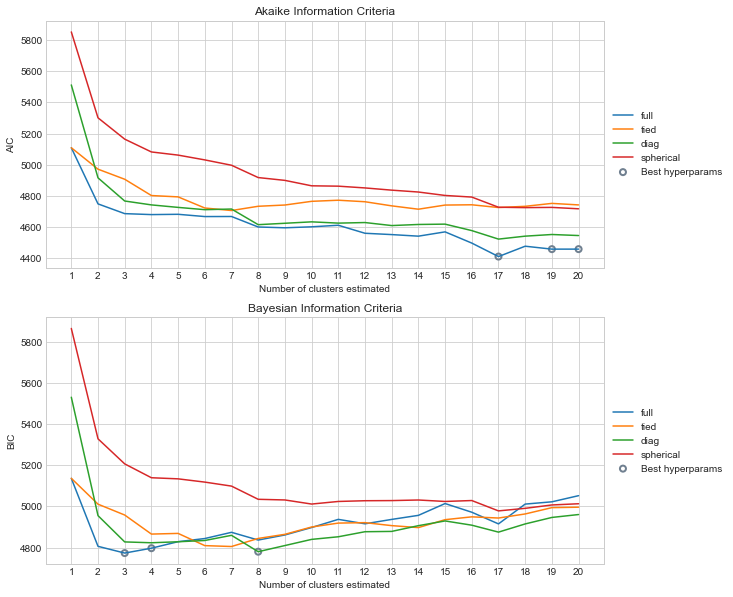

In [6]:
plt.figure(figsize=(10, 10))
afx.gmm_information_criteria_report(df.loc[:,'glucose':'sspg'], k = np.arange(1, 21))

En el eje X se encuentra la cantidad de clusters estimados y en el eje Y el criterio de
información asociado. Cada línea representa una especificación de la estructura de
covarianza implementada en el modelo, detalle que nos enfocaremos posteriormente. Los
gráficos reportan con un círculo cuales son las mejores combinaciones de hiper parámetros
para nuestro modelo de mezclas. Mientras que en base al Criterio de Información de Akaike
(AIC) los óptimos sugieren una estructura de covarianza full con un número de clusters
entre 17, 19 y 20; el Criterio de Información Bayesiano (BIC) sugiere evidencia a favor de las
estructuras de covarianza full y diag con un número de clusters mucho más bajo entre 3,
4 y 8. Ignorando el hecho que tenemos información previa sobre cuál es la cantidad de
grupos existentes en la matriz de datos, cabe señalar que el BIC llega a una conclusión
similar. En base a esta información optamos por el modelo "más parsimonioso".

La pregunta más importante respecto a esta técnica es qué son y cómo discernimos entre
los criterios de información. Cuando realizamos la estimación de todos los posibles
modelos candidatos, buscamos encontrar "el modelo correcto" que resuma de mejor manera
los datos. Todos los criterios de información provienen del concepto Desviación (conocido
como Divergencia Kullbach-Leibler en la literatura de las ciencias de la computación). La
desviación evalúa el modelo respecto a qué tan cercano son los valores predichos de los
valores "verdaderos". Mientras los valores en nuestra desviación sean menores, éstos
estarán asociados a un modelo que se ajusta de mejor manera a los datos. La principal
diferencia entre éstos y las medidas crudas de verosimilitud es que los criterios de
información penalizan por la cantidad de parámetros incluídos en el modelo.

Dentro de la interfaz de GaussianMixture se reportan dos de los criterios de información
más utilizados:

- Akaike (AIC): Ajusta la máxima logverosimilitud del modelo mediante la siguiente
  fórmula: 𝐴𝐼𝐶 =− 2(𝐿 donde -2 es la penalización asignada al
  𝑀𝑜𝑑𝑒𝑙𝑜 − 𝑝𝑎𝑟𝑎𝑚𝑠)
  puntaje.
- Schwarz-Bayesiano (BIC): Ajusta la máxima logverosimilitud del modelo mediante la
  siguiente fórmula: 𝐵𝐼𝐶 = 𝑙𝑛(𝑝𝑎𝑟𝑎𝑚𝑠)(𝐿 donde es la
  𝑀𝑜𝑑𝑒𝑙𝑜 − 𝑝𝑎𝑟𝑎𝑚𝑠) 𝑙𝑛(𝑝𝑎𝑟𝑎𝑚𝑠)
  penalización asignada al puntaje.
  
A diferencia de AIC donde ésta es constante, en el criterio BIC se penaliza de forma
dinámica por la cantidad de parámetros existentes, por lo que siempre priorizará modelos
con una menor cantidad de parámetros. Esto genera modelos más parsimoniosos a riesgo
de aumentar el sesgo (Ver más información en Dziak et al. 2012).

In [7]:
x_mat = df.loc[:,'glucose':'sspg']
X = StandardScaler().fit_transform(x_mat)
df['y'] = LabelEncoder().fit_transform(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X,df['y'], random_state=15820,test_size=.33)
# Implementaremos un modelo GMM con tres componentes
# acorde a lo informado por el criterio BIC
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=323).fit(X_train)
predict_classes_gmm = gmm.predict(X_test)

In [8]:
print(classification_report(y_test,predict_classes_gmm))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        12

    accuracy                           0.19        48
   macro avg       0.25      0.23      0.24        48
weighted avg       0.20      0.19      0.19        48



Dado que tenemos información sobre las clases verdaderas y el algoritmo genera una serie
de clasificaciones en base a las densidades inferidas, podemos generar un reporte de
clasificación. Éste genera un desempeño predictivo de 69% (representado mediante el
puntaje f1). A rasgos generales, se observa que el modelo presenta un mejor desempeño en
identificar aquellas instancias donde la predicción fue correcta considerando positivos y
negativos (precisión de 83%) por sobre la identificación de todas las instancias positivas.

In [13]:
# para cada clase
for i,n in enumerate(df['class'].unique()):
    # extraemos la densidad reportada del modelo
    print(f'Ponderador para clase {i}: {gmm.weights_[i]}')
    for j, k in enumerate(x_mat.columns):
        # dentro de cada clase extraemos la media de los atributos
        print(f'Media {k}: {gmm.means_[i][j]}')
        # y la matriz de covarianza entre éstos, condicional a la clase
        print(f'Covarianza {k}: {gmm.covariances_[i][j]}')
    print("\n", 50 * '=', "\n")

Ponderador para clase 0: 0.2120631585367023
Media glucose: -0.30838788492194935
Covarianza glucose: [0.0231439  0.01155861 0.02783513]
Media insulin: -0.15436162947752102
Covarianza insulin: [0.01155861 0.02803336 0.03065575]
Media sspg: 0.9333076930579476
Covarianza sspg: [0.02783513 0.03065575 1.70880225]


Ponderador para clase 1: 0.2399357950256921
Media glucose: 1.419235926024248
Covarianza glucose: [ 1.63918417  1.32717201 -0.45817223]
Media insulin: 1.514895029555262
Covarianza insulin: [ 1.32717201  1.15321461 -0.38901157]
Media sspg: -0.80938665211831
Covarianza sspg: [-0.45817223 -0.38901157  0.20855988]


Ponderador para clase 2: 0.5480010464376056
Media glucose: -0.46888528963820164
Covarianza glucose: [0.01399301 0.00317337 0.00434598]
Media insulin: -0.6058640385200595
Covarianza insulin: [0.00317337 0.01392501 0.00664217]
Media sspg: -0.15763581989026829
Covarianza sspg: [0.00434598 0.00664217 0.1922332 ]




Una vez con las clases inferidas, podemos caracterizar cada uno de los grupos en base a
sus atributos univariados. El primer grupo inferido presenta niveles de glucosa e insulina
negativos (-.27 y -.12 respectivamente), mientras que un nivel estable de glucosa positivo
(1.12). El segundo grupo presenta niveles negativos de glucosa, insulina y nivel estable de
glucosa. El tercer grupo es quizás el más fácil de discriminar dado que presenta niveles
positivos de glucosa e insulina, y bajos valores en el nivel estable de glucosa.

Un aspecto relevante a considerar es el hecho que los ponderadores deben ser positivos
cuando implementamos un modelo GMM. Los ponderadores representan la densidad
promedio de cada clase inferida, transformándolos en un análogo a la probabilidad de
ocurrencia de cada clase. Siguiendo nuestro conocimiento sobre la probabilidad básica,
sabemos que todos los elementos dentro de un espacio muestral finito deben sumar 1
(siguiendo los axiomas de Kolmogorov). Podemos comprobar esto de manera relativamente
fácil.

In [14]:
print(f''' 
Densidades de cada clase inferida: {gmm.weights_.round(3)}
Suma de densidades: {np.sum(gmm.weights_).round(3)}
''')

 
Densidades de cada clase inferida: [0.212 0.24  0.548]
Suma de densidades: 1.0



Así, observamos que la segunda clase es la que tiene una mayor densidad de ocurrencia en
el espacio muestral, mientras que las clases inferidas restantes presentan iguales chanches
de ocurrencia.

Otra de las virtudes de los modelos de mezcla gaussiana es su naturaleza generativa: Nos
permite extraer la probabilidad de clase en función de la distribución conjunta de los
atributos. De esta manera siempre nos entregará la probabilidad de ocurrencia de una
observación para todas las clases estimables. Esto se conoce como un problema
multietiqueta, donde cada una de las observaciones es una mezcla de los perfiles inferidos.

Para extraer la mezcla de probabilidad de ocurrencia en un modelo GaussianMixture,
podemos utilizar el método predict_proba para extraer la probabilidad en un conjunto de
datos. En este caso seleccionamos un rango de observaciones, donde se aprecia que para
este conjunto la mayoría de las observaciones tienen una probabilidad alta de ocurrencia en
la segunda clase inferida.

In [15]:
gmm.predict_proba(X).round(3)[60:70]

array([[0.446, 0.048, 0.505],
       [0.468, 0.041, 0.491],
       [0.293, 0.013, 0.695],
       [0.002, 0.003, 0.995],
       [0.719, 0.222, 0.06 ],
       [0.356, 0.063, 0.581],
       [0.153, 0.015, 0.832],
       [0.024, 0.003, 0.973],
       [0.981, 0.   , 0.019],
       [0.134, 0.063, 0.803]])

### Modelando la estructura de covarianza
Resulta que otro de los hiper parámetros a considerar es la estructura de covarianza que
tendrán las clases inferidas. A grandes rasgos la estructura de covarianza controla la
cantidad de grados de libertad en la forma de cada cluster. El método GaussianMixture
presenta cuatro variantes de ajustes acorde a la información entregada por la
documentación:
- "full": Es el método por defecto, los clusters toman formas elipsoidales libres
  ajustándose a los datos.
- "tied": Todos los cluster toman la misma forma. De esta forma comparten la
  misma matriz de covarianza.
- "spherical": Todos los clusters deben ser esféricos (la covarianza es igual en
  todos los componentes de la matriz), pero el diámetro puede variar dependiendo del
  grupo.
- "diag": Los clusters pueden tomar cualquier forma elipsoidal, pero éstas deben ser
  paralelas a los ejes, lo que significa que las matrices deben ser diagonales.
  
Para visualizar de mejor manera el efecto de las estructuras, simularemos el modelo de
mezcla para inferir 3 grupos. Por motivos prácticos entrenaremos el modelo en sólo dos
atributos: glucose e insuline. Las líneas rojas en cada gráfico representan las fronteras de
decisión entre clases.

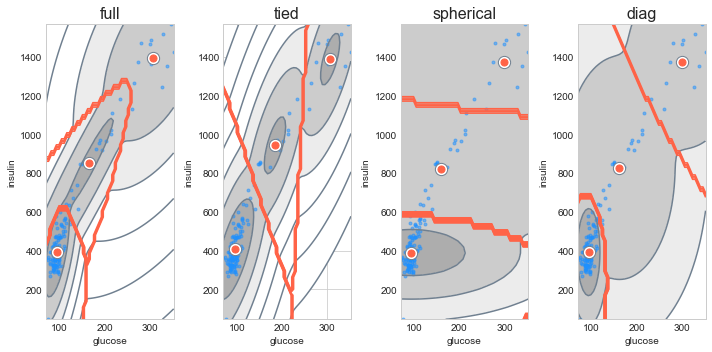

In [16]:
# Definimos la matriz de atributos
X = df.loc[:,['glucose', 'insulin']]
# definimos todas las opciones
covar_candidate = ['full', 'tied', 'spherical', 'diag']
plt.figure(figsize=(10, 5))
# para cada opción
for index, varname in enumerate(covar_candidate):
    plt.subplot(1, 4, index + 1)
    # estimamos la región de densidad con una función creada
    # los detalles se encuentran en el archivo auxiliar
    afx.plot_gaussian_ellipses(GaussianMixture(n_components = 3, covariance_type = varname, random_state = 15820).fit(X),X = X)
    plt.tight_layout(); plt.title(varname, fontsize=16)

Con la figura de arriba se aprecia que las densidades generadas con la especificación `full`
permiten una mayor flexibilidad en la estimación de densidades. El problema es que requiere
muchos grados de libertad y en situaciones donde hay una alta dimensionalidad puede ser
prohibitivo en términos computacionales. Con la especificación tied se fuerza a la
generación de densidades con una matriz de covarianza en común. Con `spherical`
forzamos a que la covarianza a nivel de grupo sea igual en todos sus componentes, pero
que pueda ser diferente entre grupos. Finalmente con la especificación `diag` la densidad
estimada puede generarse de forma independiente, pero las elipses resultantes deben estar
alineadas a los ejes.

Para efectos prácticos, la elección de la estructura de covarianza debe guiarse por el
principio de minimización de error predictivo de modelo. Cabe considerar que por lo general
aquellas estructuras que permitan una mayor flexibilidad en el ajuste de las elipses pueden
conllevar a un mayor consumo de grados de libertad y eficiencia computacional

### Efecto de la estructura de covarianza en la capacidad predictiva del modelo
Volviendo a nuestro ejemplo, no debemos conformarnos con visualizar el acople de las
densidades respecto a los datos. También debemos juzgar la capacidad predictiva del
modelo. Dado que ya tenemos información sobre las etiquetas de las observaciones, este
procedimiento es relativamente simple. Partamos por iterar nuestro modelo definido
anteriormente condicional a cada una de las estructuras. Posteriormente solicitaremos un
reporte de clasificación en los datos de validación.


In [19]:
for covar in ['full', 'tied', 'spherical', 'diag']:
    tmp_gmm = GaussianMixture(n_components = 3, covariance_type = covar, random_state = 15820).fit(X_train)
    print(covar, "\n", classification_report(y_test,tmp_gmm.predict(X_test)))

full 
               precision    recall  f1-score   support

           0       0.26      0.62      0.36        13
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        12

    accuracy                           0.17        48
   macro avg       0.09      0.21      0.12        48
weighted avg       0.07      0.17      0.10        48

tied 
               precision    recall  f1-score   support

           0       0.24      0.69      0.36        13
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        12

    accuracy                           0.19        48
   macro avg       0.08      0.23      0.12        48
weighted avg       0.07      0.19      0.10        48

spherical 
               precision    recall  f1-score   support

           0       0.25      0.62      0.36        13
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00      

Si nos fijamos en las alternativas, aquella que maximiza la capacidad predictiva del modelo
es cuando especificamos que la matriz de covarianza seguirá una estructura diagonal. Para
este caso los puntajes de desempeño global arrojan un 83%, marcando una mejora de 14
puntos porcentuales en comparación al modelo original dónde full es la opción por
defecto. Un elemento a considerar para posteriores análisis es el mal desempeño del
modelo en clasificar de forma correcta aquellas observaciones que fueron 0. Una
explicación tentativa es la fuerte comunalidad de atributos entre las clases 0 y 2. Como
siempre, nuestra estrategia de mejora del modelo debe guiarse por la obtención de más
datos tanto en validación como entrenamiento.

### GMM para la detección de anomalías
Dado que el modelo de mezclas de gaussianas impone una distribución multivariada normal
en cada una de las densidades inferidas, es posible juzgar qué tan alejada se encuentra una
observación específica respecto a las densidades. Dentro del contexto de los modelos de
mezcla, una anomalía puede significar una observación clasificada erróneamente en base a
la densidad más cercana.

Como las densidades son de carácter multivariado podemos implementar una norma de
"qué tan alejada se encuentra una observación respecto a su punto de origen", un ejercicio
similar al cuando nos preguntamos por la existencia de valores tanto más extremos que
cierto puntaje de corte en las pruebas de hipótesis. Para efectos prácticos del ejercicio,
restringimos la detección de anomalías entre sspg e insulin. Aún así, el procedimiento es
idéntico en la medida que la cantidad de atributos aumenta en la matriz.

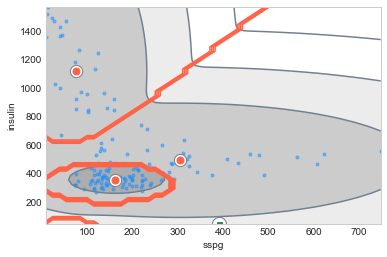

In [20]:
# Separamos la matriz
X = df.loc[:,['sspg', 'insulin']]
# Implementamos un modelo con los hiperparámetros informados anteriormente
model = GaussianMixture(n_components=3, covariance_type='diag',
random_state=323).fit(X)
# Implementamos la función
afx.plot_gaussian_ellipses(model, X=X)
X= np.array(X)
# Dado que nuestro espacio de densidades se basa en la logverosimilitud, implementamos
# la función score_samples
densities = model.score_samples(X)
# extraemos las observaciones que se sitúen en el 5% superior
thres = np.percentile(densities,.5)
# filtamos todas aquellas observaciones cuyas densidades sean menores al puntaje
anomalies = X[densities < thres]
# graficamos
plt.scatter(anomalies[:, 0], anomalies[:, 1],edgecolor = 'slategrey', facecolor = 'white', marker = 'o', s = 200)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color = 'seagreen', marker = 's', s = 25);


El gráfico nos informa la existencia de sólo 1 observación que se escapa de las densidades
multivariadas de las clases. Podemos extraer cuáles son los valores específicos con:

In [21]:
anomalies

array([[392,  45]], dtype=int64)

Esta observación anómala presenta un nivel de sspg de 392 y un nivel de insulin de 45. De
acuerdo al modelo, una observación con estas características debiese ser un 2.

In [22]:
print(model.predict([anomalies[0]]))

[2]


Pero si realizamos un análisis de los datos, observamos que esta observación es un 0. Esta
información nos permite recabar más detalles sobre qué otros factores pueden conllevar a
este paciente a tener esa clasificación.

In [23]:
df.query("sspg == {} and insulin == {}".format(anomalies[0][0], anomalies[0][1]))

,class,glucose,insulin,sspg,y
103,Chemical,75,45,392,0


### Consideraciones
Siguiendo a McLachlan y Krishnan (2008) y Blei (2012) la relevancia del algoritmo EM es que
nos permite generar estimaciones de variables latentes mediante máxima verosimilitud.
Marcó un hito en el desarrollo de modelos en estadística, machine learning, procesamiento
de señales, visión de computadores, procesamiento natural del lenguaje, genómicas, por
nombrar algunas.

Con EM los datos perdidos dejaron de ser un impedimento al plantear las siguientes ideas:
- Imaginemos que podemos observar todos los datos. En este contexto puedo estimar
  un estimador de máxima verosimilitud.
- Aún si es que no puedo observar todos los datos, puedo completar la información
  faltante de la función objetivo mediante EM para obtener un estimador de máxima
  verosimilitud.
  
EM es un buen punto de partida para implementar variadas soluciones:
- Imputar datos perdidos en datos como imágenes y encuestas.
- Estimador de modelos financieros y series temporales.
- Extracción de items y clusters en base a información del usuario en marketing.
- Extracción e inferencia de tópicos en texto.

También es un punto de partida para conocer métodos variacionales de inferencia a
posteriori y variantes de algoritmos Markov Chain Monte Carlo.

### eferencias
- Hagenaars, J; McCutcheon, A. 2002. Applied Latent Class Analysis.
- Little, R; Rubin, D. 2002. Statistical Analysis with Missing Data.
- Dziak, J; Coffman, D; Lanza, S; Runze, L. 2012. Sensitivity and Specificity of
  Information Criteria. The Methodology Center, The Pennsylvania State University.
  Technical Report Series #12-119
  https://methodology.psu.edu/media/techreports/12-119.pdf
- Dempster, A; Laird, N; Rubin, D. 1997. Maximum Likelihood from Incomplete Data via
  the EM Algorithm. Journal of the Rotal Statistical Society. Series B (Methodological),
  Vol. 39(1).
- Hastie, T; Tibshirani, R; Friedman, J. 2008. The Elementos fo Statistical LEarning.
  DAta Mining, Inference, and PRedikction. New York: Springer.
- Murphy, K. 2012. Machine Learning. A Probabilistic Perspective. Cambridge, MA:
  Massachusetts Institute of Technology Press. Ch 133: Mixture Models and the EM
  algorithm. 11.4: The EM Algorithm.
- Blei, David. 2012. Mixture Models and Expectation-Maximization. COS424: Interacting
  with Data. Princeton University [Link]
  
#### Apéndice: Formalización del Algoritmo EM
Caveat: la exposición formal del algoritmo se basa en Murphy (2012).
El objetivo es maximizar la logverosimilitud de los datos completos con la siguiente
representación:

$$\ell(\theta) = \sum_{i=1}^{N} log p(x|\theta) = \sum_{i=1}^{N} log \lbrack \sum pr(x_i z| \theta) \rbrack $$

El problema con la expresión de arriba es que es difícil de optimizar dado la incapacidad de
poder ingresar el logaritmo dentro de la sumatoria. El algoritmo propone la siguiente
solución:
Partamos por definir la logverosimilitud de los datos completos como:

$$\ell Completos(\theta) = \sum_{i=1}^{N} log \hspace{3mm} Pr(x_i z| \theta) $$

Dado que no 𝑧𝑖 se puede estimar dado que es desconocido, podemos definir la esperanza
de la logverosimilitud de los datos completos como:

$$\wp(\theta,\theta^-1) = \mathbb E \lbrack \ell(\theta)|Data, \theta^-1 \rbrack$$

Donde t es la iteración actual. En la expresión denotamos una función auxiliar como Q, que
permite actualizar la esperanza respecto al parámetros en la iteración anterior θ𝑡 − 1 y los
datos observadores. En este punto se buscan los términos que afectan a nuestro estimador
de verosimilitud.

Posteriormente, optimizamos la función auxiliar Q respecto al parámetro θ con la expresión:

$$\theta^t = argmax \wp(\theta,\theta^-1)$$

Si la estrategia de optimización busca un máximo a posteriori, podemos reemplazar el paso
de maximización a:

$$\theta^t = argmax \wp(\theta,\theta^-1) + log \hspace{3mm} Pr(\theta)$$